In [18]:
import sys
sys.path.append("../")

In [19]:
import os

In [20]:
fasttext_path = "/home/david/Programming/repos/facebookresearch/fastText/fasttext"

In [27]:
europarl_path = "/home/david/Programming/data/WMT/europarl"
europarl_all = os.path.join(europarl_path, "txt_noxml", "europarl.tokenized.all")
ftmodel_baseline = os.path.join(europarl_path, "models", "europarl_lid.baseline")
ftmodel_baseline_bin = ftmodel_baseline + ".bin"
ftmodel_baseline_ftz = ftmodel_baseline + ".ftz"
europarl_test = os.path.join(europarl_path, "test", "europarl.tokenized.test")

!$fasttext_path supervised -input $europarl_all -output $ftmodel_baseline
!$fasttext_path quantize -output $ftmodel_baseline -input $europarl_all -qnorm -retrain -epoch 1 -cutoff 100000
!$fasttext_path test $ftmodel_baseline_bin $europarl_test
!$fasttext_path test $ftmodel_baseline_ftz $europarl_test

Read 770M words
Number of words:  4642493
Number of labels: 21
Progress: 100.0% words/sec/thread:  750086 lr:  0.000000 loss:  0.016697 ETA:   0h 0m 22.8% words/sec/thread:  743924 lr:  0.077164 loss:  0.030896 ETA:   0h 5m
Progress: 100.0% words/sec/thread:  808464 lr:  0.000000 loss:  0.009479 ETA:   0h 0m
N	21000
P@1	0.997
R@1	0.997
N	21000
P@1	0.997
R@1	0.997


In [28]:
europarl_train = os.path.join(europarl_path, "txt_noxml", "europarl.tokenized.split.train")
europarl_valid = os.path.join(europarl_path, "txt_noxml", "europarl.tokenized.split.valid")
ftmodel_min50 = os.path.join(europarl_path, "models", "europarl_lid.min50")
ftmodel_min50_bin = ftmodel_min50 + ".bin"

!$fasttext_path supervised -input $europarl_train -output $ftmodel_min50 -minCount 50
!$fasttext_path test $ftmodel_min50_bin $europarl_valid

Read 763M words
Number of words:  411624
Number of labels: 21
Progress: 100.0% words/sec/thread:  762807 lr:  0.000000 loss:  0.019602 ETA:   0h 0m 0.050105 loss:  0.026668 ETA:   0h 3m
N	100000
P@1	0.997
R@1	0.997


In [37]:
ft_models_path = os.path.join(europarl_path, "models")
!ls -lh $ft_models_path

total 33G
-rw-rw-r-- 1 david david 1,9G Dez  2 20:35 europarl_lid.baseline.bin
-rw-rw-r-- 1 david david 6,9M Dez  2 20:42 europarl_lid.baseline.ftz
-rw-rw-r-- 1 david david 4,6G Dez  2 20:39 europarl_lid.baseline.vec
-rw-rw-r-- 1 david david 166M Dez  2 20:52 europarl_lid.min50.bin
-rw-rw-r-- 1 david david 409M Dez  2 20:53 europarl_lid.min50.vec
-rw-rw-r-- 1 david david 1,9G Nov 30 11:43 europarl_lid.model.baseline.bin
-rw-rw-r-- 1 david david 6,9M Nov 30 12:03 europarl_lid.model.baseline.ftz
-rw-rw-r-- 1 david david 4,6G Nov 30 11:46 europarl_lid.model.baseline.vec
-rw-rw-r-- 1 david david 3,4G Nov 22 23:12 europarl_lid.model.bin
-rw-rw-r-- 1 david david 586M Nov 22 23:30 europarl_lid.model.ftz
-rw-rw-r-- 1 david david 1,7G Nov 26 19:56 europarl_lid.model.min2.bin
-rw-rw-r-- 1 david david 4,2G Nov 26 19:59 europarl_lid.model.min2.vec
-rw-rw-r-- 1 david david 166M Nov 27 01:11 europarl_lid.model.min5.bin
-rw-rw-r-- 1 david david  18K Nov 26 20:15 europarl_lid.model.min5.output
-rw-rw-

epoch,train_loss,valid_loss,accuracy
1,0.009028,0.009348,0.997070
2,0.007764,0.007926,0.997410


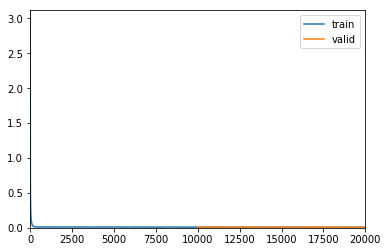

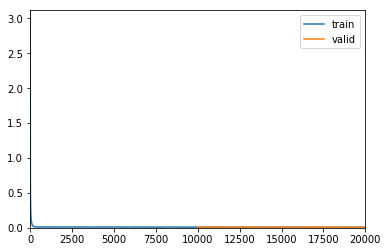

In [32]:
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.optim import SGD

from data.europarl import EUROPARLFT
from lid.ftModel import FTModel

from fastai import *

import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

europarl_basedir = "/home/david/Programming/data/WMT/europarl"

batch_size_training = 1000

ds = EUROPARLFT(europarl_basedir, split="split_train")
dl = data.DataLoader(ds, batch_size=batch_size_training, shuffle=False)
ds_valid = EUROPARLFT(europarl_basedir, split="split_valid")
dl_valid = data.DataLoader(ds_valid, batch_size=100, shuffle=False)
ds_test = EUROPARLFT(europarl_basedir, split="test")
dl_test = data.DataLoader(ds_test, batch_size=20, shuffle=False)
db = DataBunch(dl, dl_valid, test_dl=dl_test)

emb_dim = ds.embbag.weight.data.size(1)

m = FTModel(input_dim = emb_dim, layer_sizes = [1000,200])

criterion = nn.CrossEntropyLoss()

learner = Learner(db, m, loss_func = criterion, metrics=accuracy, callback_fns=ShowGraph)
learner.unfreeze()

learner.fit_one_cycle(2,1e-2)

learner.save("model_1000_200_layernorm_epoch2")


In [35]:
"""
ds_all = EUROPARLFT(europarl_basedir, split="train")
dl_all = data.DataLoader(ds, batch_size=batch_size_training, shuffle=False)
# retraining with a small dummy validation set
ds_dummy = EUROPARLFT(europarl_basedir, split="dev_train")
dl_dummy = data.DataLoader(ds, batch_size=batch_size_training, shuffle=False)
db = DataBunch(dl_all, dl_dummy)

emb_dim = ds.embbag.weight.data.size(1)

m = FTModel(input_dim = emb_dim, layer_sizes = [1000,200])

criterion = nn.CrossEntropyLoss()

learner = Learner(db, m, loss_func = criterion, metrics=accuracy, callback_fns=ShowGraph)
learner.unfreeze()

learner.fit_one_cycle(2,1e-2)

learner.save("model_1000_200_layernorm_epoch2_all")
"""

# test
m.eval()
acc = torch.tensor(0)
for mb, labels in dl_test:
    out = m(mb)
    pred = torch.topk(out, 1)[1].reshape(-1)
    acc += (pred == labels).sum()
print("Accuracy: {:.4f}%".format((acc.item() / len(ds_test))*100))


Accuracy: 99.5476%
